## Notebook to identify potential doublets in the NABEC replication cohort using Scrublet

- [Github repo](https://github.com/AllonKleinLab/scrublet)
- [repo example notebook](https://github.com/AllonKleinLab/scrublet/blob/master/examples/scrublet_basics.ipynb)
- [Cell Systems paper](https://www.sciencedirect.com/science/article/pii/S2405471218304745)

In [1]:
!date

Thu Nov  9 10:42:34 EST 2023


#### import libraries

In [2]:
import scanpy as sc
import scrublet as scr
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

%matplotlib inline
# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

ModuleNotFoundError: No module named 'scrublet'

#### set notebook variables

In [4]:
# naming
project = 'aging_phase1_nabec'

# directories
wrk_dir = '/labshare/raph/datasets/adrd_neuro/brain_aging/phase1'
replication_dir = f'{wrk_dir}/replication'

# in files
anndata_file = f'{replication_dir}/{project}.raw.h5ad'

# out files
scores_file = f'{replication_dir}/{project}.scrublet_scores.csv'
out_anndata_file = f'{replication_dir}/{project}.scrubed.h5ad'

# variables
DEBUG = True
dpi_value = 50
expected_rate = 0.08

### load the anndata files

In [6]:
%%time
adata = sc.read(anndata_file)
print(adata)

if DEBUG:
    display(adata.obs.sample(10))

AnnData object with n_obs × n_vars = 79600 × 36601
    obs: 'sample_id', 'pmi', 'sex', 'age'


,sample_id,pmi,sex,age
TAGCCTCTCGCTAAAC-1,UMARY-5171,5.0,male,79
GTTAGGCGTGATCATG-1,UMARY-5171,5.0,male,79
GATGCGACACAAACTT-1,UMARY-1710,12.0,female,26
TGCAGGCTCTCAATAG-1,UMARY-1540,7.0,male,28
CGAGCGAAGCGATAGA-1,UMARY-5088,23.0,male,66
TCATTGTTCGATTTAG-1,UMARY-1818,3.0,male,76
GGTGTGACAGGTTAAA-1,UMARY-1818,3.0,male,76
ATGTTCAAGTTGCCTC-1,UMARY-1541,19.0,female,20
GATAACGAGACTATTG-1,UMARY-1818,3.0,male,76
GGTACCGGTTAGCAGC-1,UMARY-5088,23.0,male,66


CPU times: user 200 ms, sys: 522 ms, total: 721 ms
Wall time: 721 ms


### Initialize Scrublet object
The relevant parameters are:

- expected_doublet_rate: the expected fraction of transcriptomes that are doublets, typically 0.05-0.1. Results are not particularly sensitive to this parameter. For this example, the expected doublet rate comes from the Chromium User Guide: https://support.10xgenomics.com/permalink/3vzDu3zQjY0o2AqkkkI4CC
- sim_doublet_ratio: the number of doublets to simulate, relative to the number of observed transcriptomes. This should be high enough that all doublet states are well-represented by simulated doublets. Setting it too high is computationally expensive. The default value is 2, though values as low as 0.5 give very similar results for the datasets that have been tested.
- n_neighbors: Number of neighbors used to construct the KNN classifier of observed transcriptomes and simulated doublets. The default value of round(0.5*sqrt(n_cells)) generally works well.

In [5]:
%%time
scrub = scr.Scrublet(adata.X, expected_doublet_rate=expected_rate)

CPU times: user 41.8 s, sys: 1.66 s, total: 43.4 s
Wall time: 43.4 s


### Run the default pipeline, which includes:
1. Doublet simulation
2. Normalization, gene filtering, rescaling, PCA
3. Doublet score calculation
4. Doublet score threshold detection and doublet calling

In [6]:
%%time
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.30
Detected doublet rate = 3.9%
Estimated detectable doublet fraction = 39.7%
Overall doublet rate:
	Expected   = 8.0%
	Estimated  = 9.7%
Elapsed time: 968.0 seconds
CPU times: user 1h 10min 8s, sys: 3min 47s, total: 1h 13min 56s
Wall time: 16min 8s


### Plot doublet score histograms for observed transcriptomes and simulated doublets
The simulated doublet histogram is typically bimodal. The left mode corresponds to "embedded" doublets generated by two cells with similar gene expression. The right mode corresponds to "neotypic" doublets, which are generated by cells with distinct gene expression (e.g., different cell types) and are expected to introduce more artifacts in downstream analyses. Scrublet can only detect neotypic doublets.

To call doublets vs. singlets, we must set a threshold doublet score, ideally at the minimum between the two modes of the simulated doublet histogram. scrub_doublets() attempts to identify this point automatically and has done a good job in this example. However, if automatic threshold detection doesn't work well, you can adjust the threshold with the call_doublets() function. For example:

scrub.call_doublets(threshold=0.25)

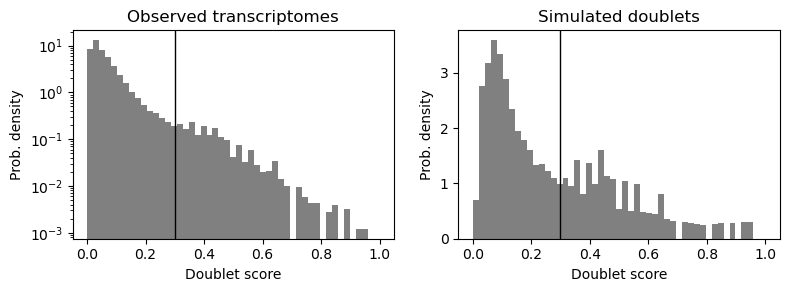

In [7]:
with rc_context({'figure.figsize': (9, 9), 'figure.dpi': dpi_value}):
    plt.style.use('seaborn-bright')
    scrub.plot_histogram()

### Get 2-D embedding to visualize the results

In [8]:
print('Running UMAP...')
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))

print('Done.')

Running UMAP...
Done.


### Plot doublet predictions on 2-D embedding
Predicted doublets should co-localize in distinct states.

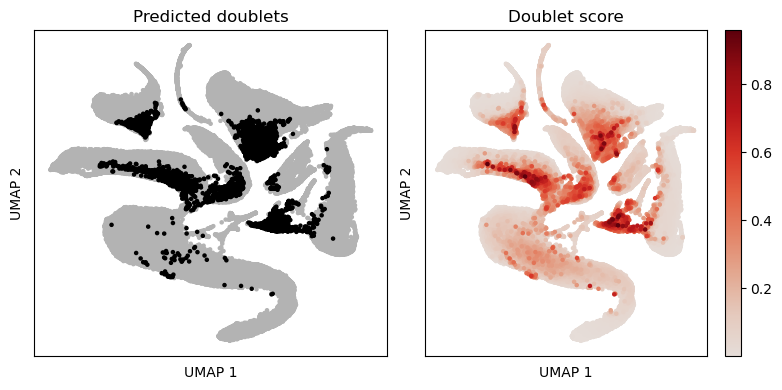

In [9]:
with rc_context({'figure.figsize': (9, 9), 'figure.dpi': dpi_value}):
    plt.style.use('seaborn-bright')
    scrub.plot_embedding('UMAP', order_points=True)

### add the scores the the cell observations

In [10]:
adata.obs['doublet_score'] = doublet_scores
adata.obs['predicted_doublet'] = predicted_doublets

In [11]:
display(adata.obs.predicted_doublet.value_counts())

False    119114
True       4780
Name: predicted_doublet, dtype: int64

### save the scores

In [12]:
adata.obs.to_csv(scores_file)

In [13]:
!date

Tue Aug 23 20:53:29 UTC 2022
